In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sncosmo
import glob
import ipywidgets as widgets
import scipy
import math
import GPy

The MLCS2k2 (Jha et al. 2007) empirical description of the observed apparent magnitude of type Ia supernovae is given by

$$ \textbf{m}_X(t-t_0)= \textbf{M}_X^0 +\mu_0 +\boldsymbol{\zeta}_X \left(\alpha_X +\frac{\beta_X}{R_V} \right)A_V^0 + \textbf{P}_X\Delta +\textbf{Q}_X\Delta^2 $$

where, $\textbf{M}_X^0$, $\textbf{P}_X$, $\textbf{Q}_X$, $\boldsymbol{\zeta}_X$, $\alpha_X$ and $\beta_X$ are obtained from a training sample. The third term corrects for dust extinction in the supernova host galaxy, $\boldsymbol{\zeta}_X$ captures the time dependence of this correction, $\alpha_X$ and $\beta_X$ are constant values. Below we see the plots for every time dependent template involved in this description, i.e. $\textbf{M}_X^0$, $\textbf{P}_X$, $\textbf{Q}_X$, $\boldsymbol{\zeta}_X$, where X stands for one of the filters where the model is trained, X={U,B,V,R,I}.

The lc fitting process consists in minimizing the $\chi^2$ of residues below with covariance given by a model covariance matrix S plus a noise matrix N. Together with a prior probability distribution for each model parameter, i.e. $t_0$,$\mu_0$,$\Delta$,$A_V^0$,$R_V$, we obtain the best fit values.

$$ \chi^2 = \textbf{r}^{T} C^{-1} \textbf{r} $$

$$ C = S + N $$

$$ \chi^2 =  \textbf{r}^{T} C^{-1} \textbf{r}-2\ln \hat{p}(t_0,\mu_0,\Delta,A_V^0,R_V) $$

In the training process, to obtain $\textbf{M}_X^0$, $\textbf{P}_X$, $\textbf{Q}_X$ and model cov matrix S we depart from an initial guess for the model parameters ($t_0$,$\mu_0$,$\Delta$,$A_V^0$,$R_V$) for each training SN. We then perform the lc fitting using these model vector for the same set and reobtain the model parameters. We iterate this process until convergence is reached.

## Original model vectors

In [2]:
zeta=pd.read_csv("original_model_templates/zeta.dat",sep='\s+',comment='#',header=None)
zeta.columns=["#phase", "zeta_U", "zeta_B", "zeta_V", "zeta_R", "zeta_I"]

zeta=zeta[(zeta["#phase"]>-11.) & (zeta["#phase"]<51.)]

In [3]:
alphabeta=pd.read_csv("original_model_templates/alphabeta.dat",sep='\s+',comment='#',header=None)

alpha={}
beta={}

for i in alphabeta[0]:
    alpha[i]=alphabeta[alphabeta[0]==i][1].values[0]
    beta[i]=alphabeta[alphabeta[0]==i][2].values[0]

In [4]:
vec_U=pd.read_csv('./original_model_templates/vectors_U.dat',sep='\s+') # M^0_U, P_U, Q_U
vec_B=pd.read_csv('./original_model_templates/vectors_B.dat',sep='\s+') # M^0_B, P_B, Q_B
vec_V=pd.read_csv('./original_model_templates/vectors_V.dat',sep='\s+') # M^0_V, P_V, Q_V
vec_R=pd.read_csv('./original_model_templates/vectors_R.dat',sep='\s+') # M^0_R, P_R, Q_R
vec_I=pd.read_csv('./original_model_templates/vectors_I.dat',sep='\s+') # M^0_I, P_I, Q_I

In [5]:
vec_U=vec_U[(vec_U["#phase"]>-11.) & (vec_U["#phase"]<51.)] 
vec_B=vec_B[(vec_B["#phase"]>-11.) & (vec_B["#phase"]<51.)] 
vec_V=vec_V[(vec_V["#phase"]>-11.) & (vec_V["#phase"]<51.)] 
vec_R=vec_R[(vec_R["#phase"]>-11.) & (vec_R["#phase"]<51.)] 
vec_I=vec_I[(vec_I["#phase"]>-11.) & (vec_I["#phase"]<51.)] 

In [6]:
vec={"U":vec_U,"B":vec_B,"V":vec_V,"R":vec_R,"I":vec_I}

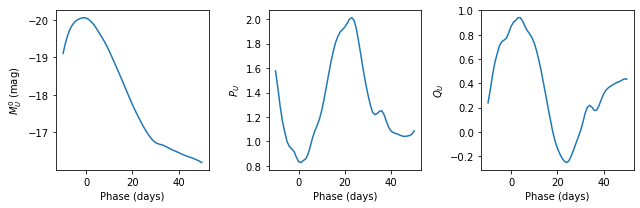

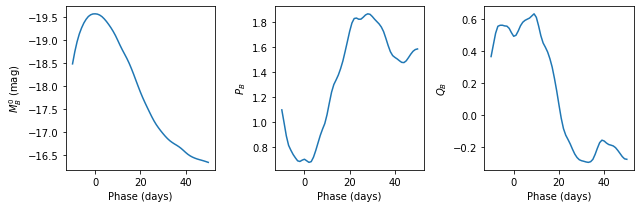

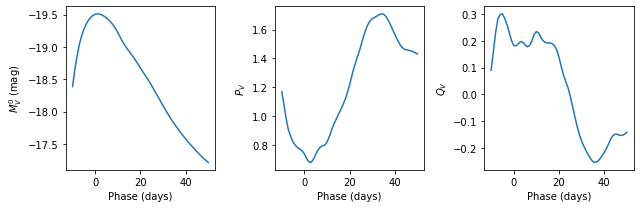

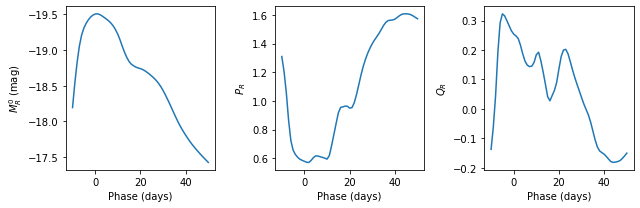

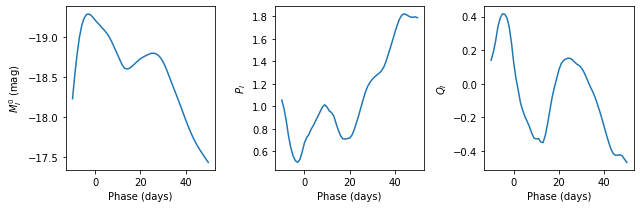

In [7]:
for filt in ["U","B","V","R","I"]:
    fig,axs= plt.subplots(1,3,figsize=(9,3))

    axs[0].plot(vec[filt]["#phase"],vec[filt]["M^0_"+filt])
    axs[0].invert_yaxis()
    axs[0].set_xlabel("Phase (days)")
    axs[0].set_ylabel(r"$M^0_"+filt+"$ (mag)")
    axs[1].plot(vec[filt]["#phase"],vec[filt]["P_"+filt])
    axs[1].set_xlabel("Phase (days)")
    axs[1].set_ylabel(r"$P_"+filt+"$") # checar unidade
    axs[2].plot(vec[filt]["#phase"],vec[filt]["Q_"+filt])
    axs[2].set_xlabel("Phase (days)")
    axs[2].set_ylabel(r"$Q_"+filt+"$") # checar unidade
    plt.tight_layout();

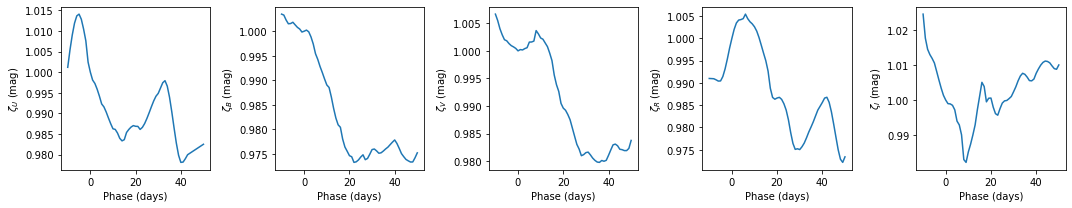

In [8]:
fig,axs= plt.subplots(1,5,figsize=(15,3))

for i,filt in enumerate(["U","B","V","R","I"]):
    axs[i].plot(zeta["#phase"],zeta["zeta_"+filt])
    axs[i].set_xlabel("Phase (days)")
    axs[i].set_ylabel(r"$\zeta_"+filt+"$ (mag)")
    
plt.tight_layout();

Now, we will attemp to reobtain the model vectors given the observed light curves of the training set avaiable on SNANA and the estimatives of the model parameters ($t_0$,$\mu_0$,$\Delta$,$A_V^0$,$R_V$) given by Jha et al. 2007 itself.

## Training Sample

In [9]:
U_files=glob.glob("./outputs/dat/*U.dat")
B_files=glob.glob("./outputs/dat/*B.dat")
V_files=glob.glob("./outputs/dat/*V.dat")
R_files=glob.glob("./outputs/dat/*R.dat")
I_files=glob.glob("./outputs/dat/*I.dat")

In [10]:
U_data={}
B_data={}
V_data={}
R_data={}
I_data={}

In [11]:
for file_U in U_files:
    U_data[file_U.split("_")[0].split("/")[3][2:]]=pd.read_csv(file_U,sep="\s+",header=None).values.reshape(-1)

for file_B in B_files:
    B_data[file_B.split("_")[0].split("/")[3][2:]]=pd.read_csv(file_B,sep="\s+",header=None).values.reshape(-1)

for file_V in V_files:
    V_data[file_V.split("_")[0].split("/")[3][2:]]=pd.read_csv(file_V,sep="\s+",header=None).values.reshape(-1)

for file_R in R_files:
    R_data[file_R.split("_")[0].split("/")[3][2:]]=pd.read_csv(file_R,sep="\s+",header=None).values.reshape(-1)

for file_I in I_files:
    I_data[file_I.split("_")[0].split("/")[3][2:]]=pd.read_csv(file_I,sep="\s+",header=None).values.reshape(-1)

In [12]:
data=pd.read_csv("data.txt",sep="\s+",comment="#")

In [13]:
train=["1990O","1990af","1992P","1992ae","1992al","1992bc","1992bg","1992bl","1992bo","1992bp","1992br","1993H","1993O","1993ag","1994M","1995ac","1996C","1996bl","1997E","1997Y","1997bq","1998V","1998ab","1998bp","1998de","1998es","1999aa","1999ac","1999da","1999gp","2000ca","2000cf","2000dk","2000fa","2001V","2001cz","2002er"]

In [14]:
delta={}
mu0={}
incdelta={}
A0_V={}
R_V={}
for SN in train:
    delta[SN]=data[data["SNIa"]==SN]["Delta"].values[0]
    incdelta[SN]=data[data["SNIa"]==SN]["+/-.2"].values[0]
    mu0[SN]=data[data["SNIa"]==SN]["mu0+5logh65"].values[0]
    A0_V[SN]=data[data["SNIa"]==SN]["A^0_V"].values[0]
    R_V[SN]=data[data["SNIa"]==SN]["R_V"].values[0]

In [15]:
def power_delta(p,snlist):
    s=0
    for SN in snlist:
        s+=delta[SN]**p/incdelta[SN]
    return s

In [16]:
termo_linear_U=0
termo_quadrado_U=0
for SN in U_data.keys():
    termo_linear_U+=delta[SN]*(U_data[SN]-vec["U"]["M^0_U"].values-mu0[SN]-zeta["zeta_U"].values*(alpha["U"]+beta["U"]/R_V[SN])*A0_V[SN])/incdelta[SN]
    termo_quadrado_U+=delta[SN]**2*(U_data[SN]-vec["U"]["M^0_U"].values-mu0[SN]-zeta["zeta_U"].values*(alpha["U"]+beta["U"]/R_V[SN])*A0_V[SN])/incdelta[SN]

In [17]:
termo_linear_B=0
termo_quadrado_B=0
for SN in B_data.keys():
    termo_linear_B+=delta[SN]*(B_data[SN]-vec["B"]["M^0_B"].values-mu0[SN]-zeta["zeta_B"].values*(alpha["B"]+beta["B"]/R_V[SN])*A0_V[SN])/incdelta[SN]
    termo_quadrado_B+=delta[SN]**2*(B_data[SN]-vec["B"]["M^0_B"].values-mu0[SN]-zeta["zeta_B"].values*(alpha["B"]+beta["B"]/R_V[SN])*A0_V[SN])/incdelta[SN]

In [18]:
termo_linear_V=0
termo_quadrado_V=0
for SN in V_data.keys():
    termo_linear_V+=delta[SN]*(V_data[SN]-vec["V"]["M^0_V"].values-mu0[SN]-zeta["zeta_V"].values*(alpha["V"]+beta["V"]/R_V[SN])*A0_V[SN])/incdelta[SN]
    termo_quadrado_V+=delta[SN]**2*(V_data[SN]-vec["V"]["M^0_V"].values-mu0[SN]-zeta["zeta_V"].values*(alpha["V"]+beta["V"]/R_V[SN])*A0_V[SN])/incdelta[SN]

In [19]:
termo_linear_R=0
termo_quadrado_R=0
for SN in R_data.keys():
    termo_linear_R+=delta[SN]*(R_data[SN]-vec["R"]["M^0_R"].values-mu0[SN]-zeta["zeta_R"].values*(alpha["R"]+beta["R"]/R_V[SN])*A0_V[SN])/incdelta[SN]
    termo_quadrado_R+=delta[SN]**2*(R_data[SN]-vec["R"]["M^0_R"].values-mu0[SN]-zeta["zeta_R"].values*(alpha["R"]+beta["R"]/R_V[SN])*A0_V[SN])/incdelta[SN]

In [20]:
termo_linear_I=0
termo_quadrado_I=0
for SN in I_data.keys():
    termo_linear_I+=delta[SN]*(I_data[SN]-vec["I"]["M^0_I"].values-mu0[SN]-zeta["zeta_I"].values*(alpha["I"]+beta["I"]/R_V[SN])*A0_V[SN])/incdelta[SN]
    termo_quadrado_I+=delta[SN]**2*(I_data[SN]-vec["I"]["M^0_I"].values-mu0[SN]-zeta["zeta_I"].values*(alpha["I"]+beta["I"]/R_V[SN])*A0_V[SN])/incdelta[SN]

In [21]:
P_U=(termo_quadrado_U*power_delta(3,U_data.keys())-termo_linear_U*power_delta(4,U_data.keys()))/(power_delta(3,U_data.keys())**2-power_delta(4,U_data.keys())*power_delta(2,U_data.keys()))
Q_U=(termo_quadrado_U*power_delta(2,U_data.keys())-termo_linear_U*power_delta(3,U_data.keys()))/(power_delta(4,U_data.keys())*power_delta(2,U_data.keys())-power_delta(3,U_data.keys())**2)

In [22]:
P_B=(termo_quadrado_B*power_delta(3,B_data.keys())-termo_linear_B*power_delta(4,B_data.keys()))/(power_delta(3,B_data.keys())**2-power_delta(4,B_data.keys())*power_delta(2,B_data.keys()))
Q_B=(termo_quadrado_B*power_delta(2,B_data.keys())-termo_linear_B*power_delta(3,B_data.keys()))/(power_delta(4,B_data.keys())*power_delta(2,B_data.keys())-power_delta(3,B_data.keys())**2)

In [23]:
P_V=(termo_quadrado_V*power_delta(3,V_data.keys())-termo_linear_V*power_delta(4,V_data.keys()))/(power_delta(3,V_data.keys())**2-power_delta(4,V_data.keys())*power_delta(2,V_data.keys()))
Q_V=(termo_quadrado_V*power_delta(2,V_data.keys())-termo_linear_V*power_delta(3,V_data.keys()))/(power_delta(4,V_data.keys())*power_delta(2,V_data.keys())-power_delta(3,V_data.keys())**2)

In [24]:
P_R=(termo_quadrado_R*power_delta(3,R_data.keys())-termo_linear_R*power_delta(4,R_data.keys()))/(power_delta(3,R_data.keys())**2-power_delta(4,R_data.keys())*power_delta(2,R_data.keys()))
Q_R=(termo_quadrado_R*power_delta(2,R_data.keys())-termo_linear_R*power_delta(3,R_data.keys()))/(power_delta(4,R_data.keys())*power_delta(2,R_data.keys())-power_delta(3,R_data.keys())**2)

In [25]:
P_I=(termo_quadrado_I*power_delta(3,I_data.keys())-termo_linear_I*power_delta(4,I_data.keys()))/(power_delta(3,I_data.keys())**2-power_delta(4,I_data.keys())*power_delta(2,I_data.keys()))
Q_I=(termo_quadrado_I*power_delta(2,I_data.keys())-termo_linear_I*power_delta(3,I_data.keys()))/(power_delta(4,I_data.keys())*power_delta(2,I_data.keys())-power_delta(3,I_data.keys())**2)

In [26]:
P={"U":P_U,"B":P_B,"V":P_V,"R":P_R,"I":P_I}
Q={"U":Q_U,"B":Q_B,"V":Q_V,"R":Q_R,"I":Q_I}

In [32]:
plt.rcParams['font.size'] = '16'

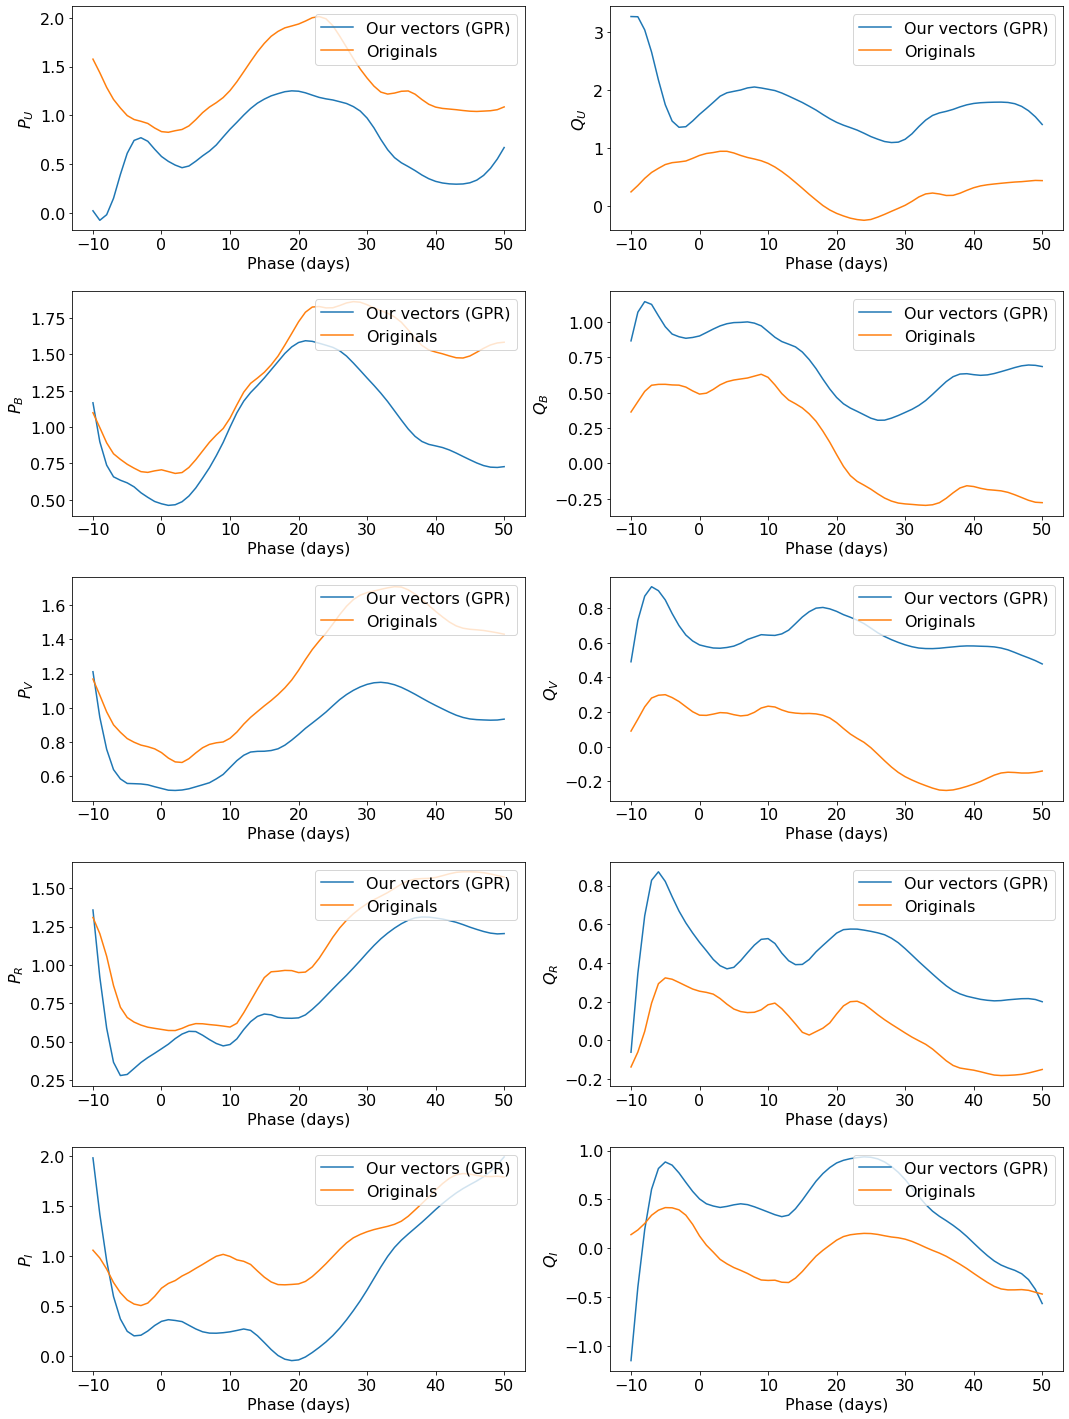

In [34]:
fig,axs= plt.subplots(5,2,figsize=(15,20))
i=0
for filt in ["U","B","V","R","I"]:
    
    axs[i,0].plot(np.arange(-10,51,1),P[filt],label="Our vectors (GPR)")
    axs[i,0].plot(np.arange(-10,51,1),vec[filt]["P_"+filt],label="Originals")
    axs[i,0].set_xlabel("Phase (days)")
    axs[i,0].set_ylabel(r"$P_"+filt+"$") # checar unidade
    axs[i,0].legend(loc=1)

    axs[i,1].plot(np.arange(-10,51,1),Q[filt],label="Our vectors (GPR)")
    axs[i,1].plot(np.arange(-10,51,1),vec[filt]["Q_"+filt],label="Originals")
    axs[i,1].set_xlabel("Phase (days)")
    axs[i,1].set_ylabel(r"$Q_"+filt+"$") # checar unidade
    axs[i,1].legend(loc=1)
    i+=1

fig.tight_layout()
plt.savefig("Comparison_model_vectors_GPR.png",facecolor='white',transparent=False);